In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import statsmodels as sm
import pmdarima as pm
from pmdarima.model_selection import train_test_split

### Parameters

In [2]:
filename = './data/ML_IGE_ENTRANTS_MODELE1.csv'

# myfilters = {'SITE':'VELIZY','FLUX_ACTIVITE':'Flux Prestation','SERVICE_ACTIVITE':'PRESTATION','MEDIA':'Courrier'}
myfilters = {'SITE':'VELIZY','FLUX_ACTIVITE':'Flux Prestation','SERVICE_ACTIVITE':'PRESTATION'}

testsize = 30

### Import csv

In [3]:
df = pd.read_csv(filename,sep=';',engine='python',index_col='DATEDATA',parse_dates=True)

### Preprocess columns

In [4]:
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

### Filter

In [5]:
def filter_df(df, mydict):
    df_filter = df.copy()
    for key,value in mydict.items():
        df_filter = df_filter[df_filter[key]==value]
    return df_filter
    
df_filter = filter_df(df, myfilters)

### Create Aggregated Df with DateTime Index

In [6]:
df2 = df_filter.groupby('DATEDATA').sum()
df2 = df2.asfreq(freq='B')
df2['TOTAL'].fillna(0,inplace=True)

### Split in train test to compare with predictions

In [7]:
train,test = train_test_split(df2, test_size=testsize)

### Model auto.arima

In [8]:
modl = pm.auto_arima(train, error_action='ignore', trace=False,
                      suppress_warnings=True, maxiter=10,
                      seasonal=True, m=5)

In [9]:
# modl.plot_diagnostics();

In [10]:
preds, conf_int = modl.predict(n_periods=test.shape[0], return_conf_int=True)

### Plot Result

In [11]:
graph = test.copy()
graph = graph.rename(columns={'TOTAL':'TEST'})
graph['preds'] = preds
graph['lb'] = conf_int[:,0]
graph['ub'] = conf_int[:,1]
graph = graph.append(train)

In [12]:
graphz = graph[graph.index>'2019-06-01']

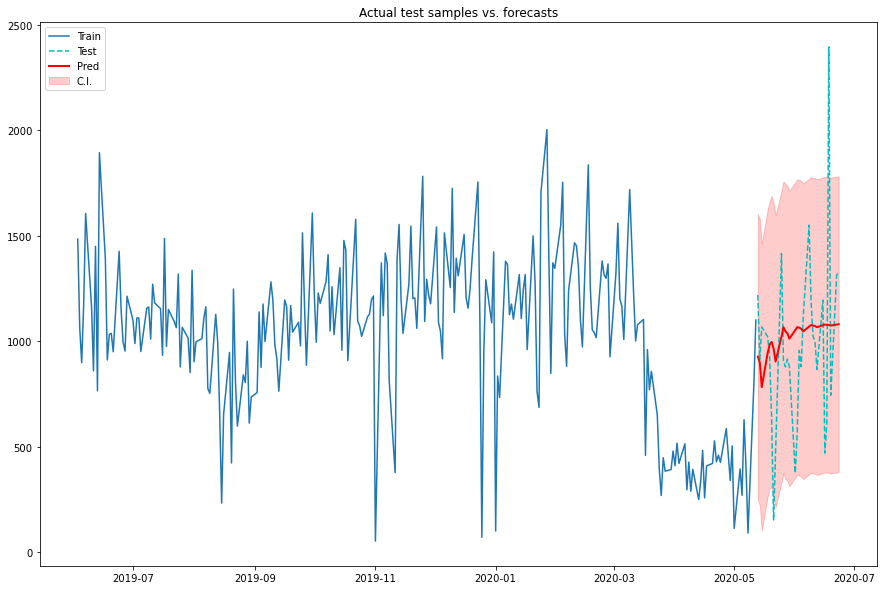

In [13]:
plt.rcParams['figure.figsize'] = [15, 10]
g1 = plt.plot(graphz.index, graphz.TOTAL, label='Train')
g2 = plt.plot(graphz.index, graphz.TEST,'c--', label='Test')
g3 = plt.plot(graphz.index, graphz.preds,'r', label='Pred',linewidth=2)
g4 = plt.fill_between(graphz.index,graphz.lb,graphz.ub,color='r',alpha=.2, label='C.I.')
plt.legend(loc='upper left')
plt.title('Actual test samples vs. forecasts')
plt.show()